In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
from scipy import stats

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model
from density_pericenter_fit_utils import run_best_fit_for_sim
from density_pericenter_fit_utils import run_best_fit_for_sim_with_mcmc
from satellite_properties_plot_utils import plot_median_relation

plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (5, 3),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

In [2]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

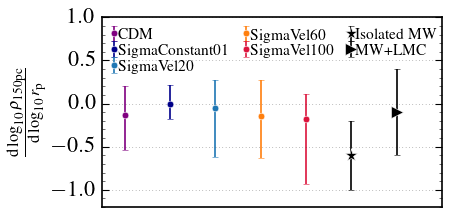

In [8]:

color_list = ["purple","darkblue","tab:blue","tab:orange","crimson"]

plt.figure()
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:8]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m) - np.percentile(m,16)
    merr[1,0]= np.percentile(m,84) - np.median(m)
    plt.errorbar(np.array([i]), np.array(np.median(m)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
                 markeredgecolor="white", ls='none', lw=1.5, label='Isolated MW', color='black')
plt.errorbar(np.array([i+2]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
                 markeredgecolor="white", ls='none', lw=1.5, label='MW+LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.1, handlelength=0.3, handletextpad=0.1, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho_{150\mathrm{pc}}}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')
plt.axis([-0.5, 7, -1.2, 1.0])
    
####
plt.savefig('Density_pericenter_slope.png',dpi=300)
plt.show()

Suppose we wish to test the null hypothesis that two samples were drawn from the same distribution.
We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative
if the p-value is less than 0.05.

In [9]:
# Create sample for observational dataset:
# This test is for the observational sample with rho_150 = Kaplighant (NFW) and r_p = MW

mu, sigma = -0.6, 0.4 # mean and standard deviation
obs_sample = np.random.normal(mu, sigma, 1000)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:8]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)

    sim_sample = m
    statistic, pvalue = stats.ks_2samp(obs_sample, sim_sample)
    print(id_name, 'Obs')
    print(np.median(m),-0.6)
    print(statistic, pvalue)
    print('===')

CDM Obs
-0.13724294404348686 -0.6
0.4662941176470588 4.6145441361560466e-07
===
SigmaConstant01 Obs
-0.003507366152777829 -0.6
0.7723939393939394 2.278546683630629e-20
===
SigmaVel20 Obs
-0.048934080157768844 -0.6
0.5545757575757576 9.510366436017609e-10
===
SigmaVel60 Obs
-0.14438742283001285 -0.6
0.44775757575757574 2.3571291232236876e-06
===
SigmaVel100 Obs
-0.18369482879127552 -0.6
0.43106060606060603 6.6283214366142725e-06
===


In [10]:
# Create sample for observational dataset:
# This test is for the observational sample with rho_150 = Kaplighant (NFW) and r_p = MW + LMC

mu, sigma = -0.1, 0.5 # mean and standard deviation
obs_sample = np.random.normal(mu, sigma, 1000)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:8]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)

    sim_sample = m
    statistic, pvalue = stats.ks_2samp(obs_sample, sim_sample)
    print(id_name, 'Obs')
    print(np.median(m),-0.1)
    print(statistic, pvalue)
    print('===')

CDM Obs
-0.13724294404348686 -0.1
0.11711764705882353 0.7130946698925904
===
SigmaConstant01 Obs
-0.003507366152777829 -0.1
0.3363939393939394 0.000998631105294714
===
SigmaVel20 Obs
-0.048934080157768844 -0.1
0.11857575757575757 0.7146086650706198
===
SigmaVel60 Obs
-0.14438742283001285 -0.1
0.13363636363636364 0.5712513244877886
===
SigmaVel100 Obs
-0.18369482879127552 -0.1
0.19903030303030303 0.13811131138773441
===


The above cells compare the simulated and observational samples based on the fit, which strongly depends on the 
method used (further discussed in Cardona+). As an alternative comparison we use the correlation coefficients

In [13]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

num_satellites = 8
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [31]:
x = np.log10(r_p_Isolated[0,:])
y = np.log10(rho_150pc_K19[0,:])
pearson_obs_MW = stats.pearsonr(x, y).statistic
spearman_obs_MW = stats.spearmanr(x, y).statistic

x = np.log10(r_p_LMC[0,:])
y = np.log10(rho_150pc_K19[0,:])
pearson_obs_MW_LMC = stats.pearsonr(x, y).statistic
spearman_obs_MW_LMC = stats.spearmanr(x, y).statistic


In [20]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    pearson_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            pearson_sim = np.append(pearson_sim, stats.pearsonr(x, y).statistic)

    print(id_name, 'Obs')
    print(np.median(pearson_sim),pearson_obs_MW, pearson_obs_MW_LMC)
    print('===')

CDM Obs
-0.3548937544735027 -0.7767308231229598 -0.25922217628117505
===
SigmaConstant01 Obs
-0.2479007952522807 -0.7767308231229598 -0.25922217628117505
===
SigmaVel20 Obs
-0.2002086161369613 -0.7767308231229598 -0.25922217628117505
===
SigmaVel60 Obs
-0.12060813641197266 -0.7767308231229598 -0.25922217628117505
===
SigmaVel100 Obs
-0.2759452910798934 -0.7767308231229598 -0.25922217628117505
===


-0.3476964102094112
-0.027301180327826483
-0.08611684371483208
-0.11195257777672757
-0.17208165375832074


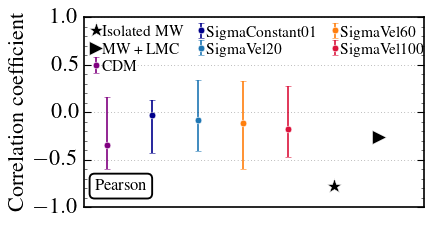

In [48]:

color_list = ["purple","darkblue","tab:blue","tab:orange","crimson"]

plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    pearson_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:10]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            pearson_sim = np.append(pearson_sim, stats.pearsonr(x, y).statistic)

    print(np.median(pearson_sim))

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(pearson_sim) - np.percentile(pearson_sim,16)
    merr[1,0]= np.percentile(pearson_sim,84) - np.median(pearson_sim)
    plt.errorbar(np.array([i]), np.array(np.median(pearson_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.plot(np.array([i+1]), np.array(pearson_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(pearson_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Pearson', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
plt.savefig('Density_pericenter_correlation_pearson.png',dpi=300)
plt.show()

-0.35757575757575755
0.0303030303030303
-0.07878787878787878
-0.11515151515151514
-0.19999999999999998


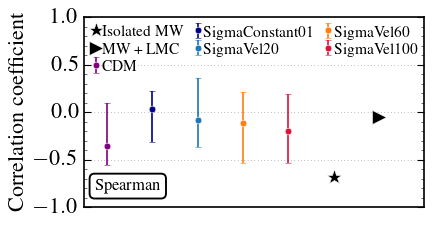

In [49]:

color_list = ["purple","darkblue","tab:blue","tab:orange","crimson"]

plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    spearman_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:10]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            spearman_sim = np.append(spearman_sim, stats.spearmanr(x, y).statistic)

    print(np.median(spearman_sim))

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(spearman_sim) - np.percentile(spearman_sim,16)
    merr[1,0]= np.percentile(spearman_sim,84) - np.median(spearman_sim)
    plt.errorbar(np.array([i]), np.array(np.median(spearman_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.plot(np.array([i+1]), np.array(spearman_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(spearman_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=0.8, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Spearman', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
plt.savefig('Density_pericenter_correlation_spearman.png',dpi=300)
plt.show()

##### 